## GraphSAGE on Cora — Enc / Gt / Dec / L

- **Encoder (Enc):** Two GraphSAGE layers (mean aggregation) transform node features into hidden embeddings while incorporating neighbor information.
- **Ground Truth (Gt):** The verified, "correct" labels used to train the model and evaluate its performance..
- **Decoder (Dec):** Final GraphSAGE layer projects embeddings to class logits, followed by softmax for per-node class probabilities.
- **Loss (L):** Masked categorical cross-entropy computed only on labeled nodes via sample weights (train/val/test masks).


## 1. Load and preprocess data 

In [7]:
import os
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from spektral.layers import GraphSageConv
from spektral.utils import convolution
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from pathlib import Path

# Locate repository root (handles running from notebooks/)
cwd = Path.cwd().resolve()
repo_root = cwd if (cwd / "data").exists() else cwd.parent
DATA_DIR = repo_root / "data"

# Load arrays
X = np.load(DATA_DIR / "X.npy").astype(np.float32)
y = np.load(DATA_DIR / "y.npy").astype(np.float32)
A = sp.load_npz(DATA_DIR / "A.npz")
train_mask = np.load(DATA_DIR / "train_mask.npy")
val_mask = np.load(DATA_DIR / "val_mask.npy")
test_mask = np.load(DATA_DIR / "test_mask.npy")

# Convert to tensors
X = tf.constant(X, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)

# Preprocess adjacency: add self-loops + symmetric normalization
A_processed = convolution.gcn_filter(A).tocoo()
A_tensor = tf.sparse.SparseTensor(
    np.array([A_processed.row, A_processed.col]).T,
    A_processed.data.astype(np.float32),
    A_processed.shape,
)
A_tensor = tf.sparse.reorder(A_tensor)

# Masks as float tensors for sample weights
train_mask = tf.constant(train_mask.astype(np.float32))
val_mask = tf.constant(val_mask.astype(np.float32))
test_mask = tf.constant(test_mask.astype(np.float32))

print("✅ Loaded data from disk successfully\n")
print(f"X shape:        {X.shape}")
print(f"y shape:        {y.shape}")
print(f"A shape:        {A.shape} (sparse)")
print(f"Train samples:  {tf.reduce_sum(train_mask).numpy()}")
print(f"Val samples:    {tf.reduce_sum(val_mask).numpy()}")
print(f"Test samples:   {tf.reduce_sum(test_mask).numpy()}")


✅ Loaded data from disk successfully

X shape:        (2708, 1433)
y shape:        (2708, 7)
A shape:        (2708, 2708) (sparse)
Train samples:  140.0
Val samples:    500.0
Test samples:   1000.0


## 2. Inspect splits and shapes

In [8]:
num_nodes, num_features = X.shape
num_classes = y.shape[1]

print("Data splits:")
print(f"  Train: {tf.reduce_sum(train_mask).numpy()} nodes")
print(f"  Val:   {tf.reduce_sum(val_mask).numpy()} nodes")
print(f"  Test:  {tf.reduce_sum(test_mask).numpy()} nodes")
print(f"  Num features: {num_features}")
print(f"  Num classes:  {num_classes}")


Data splits:
  Train: 140.0 nodes
  Val:   500.0 nodes
  Test:  1000.0 nodes
  Num features: 1433
  Num classes:  7


## 3. Build the GraphSAGE model 

In [ ]:
dropout_rate = 0.5
l2_reg = 5e-4
learning_rate = 0.01

X_in = layers.Input(shape=(num_features,), name="X_in")
A_in = layers.Input((None,), sparse=True, name="A_in")

x = layers.Dropout(dropout_rate)(X_in)
x = GraphSageConv(16, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))([x, A_in])
x = layers.Dropout(dropout_rate)(x)
outputs = GraphSageConv(num_classes, activation="softmax")([x, A_in])

model = keras.Model(inputs=[X_in, A_in], outputs=outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ X_in (InputLayer)   │ (None, 1433)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1433)      │          0 │ X_in[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ A_in (InputLayer)   │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_sage_conv_2   │ (None, 16)        │     45,872 │ dropout_2[0][0],  │
│ (GraphSageConv)     │                   │            │ A_in[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16)        │          0 │ graph_sage_conv_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_sage_conv_3   │ (None, 7)         │        231 │ dropout_3[0][0],  │
│ (GraphSageConv)     │                   │            │ A_in[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46,103 (180.09 KB)

 Trainable params: 46,103 (180.09 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Train with masked loss

2025-12-18 14:44:05.120973: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 76029248 exceeds 10% of free system memory.
2025-12-18 14:44:05.627460: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 76029248 exceeds 10% of free system memory.
2025-12-18 14:44:05.793513: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 76029248 exceeds 10% of free system memory.


Epoch 001 | loss 2.0032 | val_loss 1.9179 | train_acc 0.1786 | val_acc 0.1680


2025-12-18 14:44:05.949871: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 76029248 exceeds 10% of free system memory.
2025-12-18 14:44:06.086339: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 76029248 exceeds 10% of free system memory.


Epoch 002 | loss 1.9160 | val_loss 1.8808 | train_acc 0.1857 | val_acc 0.2380
Epoch 003 | loss 1.9378 | val_loss 1.8495 | train_acc 0.2214 | val_acc 0.2740
Epoch 004 | loss 1.8647 | val_loss 1.8186 | train_acc 0.2857 | val_acc 0.3300
Epoch 005 | loss 1.8886 | val_loss 1.7839 | train_acc 0.2286 | val_acc 0.3700
Epoch 006 | loss 1.8037 | val_loss 1.7396 | train_acc 0.3000 | val_acc 0.4140
Epoch 007 | loss 1.7988 | val_loss 1.6938 | train_acc 0.2929 | val_acc 0.4620
Epoch 008 | loss 1.7767 | val_loss 1.6571 | train_acc 0.3500 | val_acc 0.5040
Epoch 009 | loss 1.7531 | val_loss 1.6273 | train_acc 0.3286 | val_acc 0.5300
Epoch 010 | loss 1.7022 | val_loss 1.6055 | train_acc 0.4000 | val_acc 0.5700
Epoch 011 | loss 1.7353 | val_loss 1.5910 | train_acc 0.3571 | val_acc 0.5900
Epoch 012 | loss 1.7674 | val_loss 1.5803 | train_acc 0.3214 | val_acc 0.6120
Epoch 013 | loss 1.7436 | val_loss 1.5737 | train_acc 0.3929 | val_acc 0.6300
Epoch 014 | loss 1.6837 | val_loss 1.5685 | train_acc 0.4643 | v

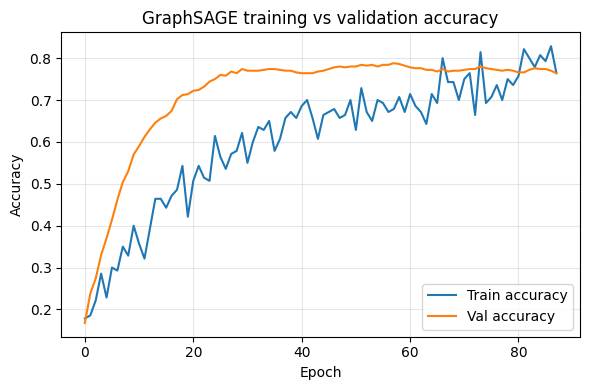

In [4]:
from datetime import datetime
epochs = 100
patience = 10
DATASET_NAME = "cora"
MODEL_NAME = "graphsage"
PLOTS_DIR = os.path.join("..", "results", "plots", MODEL_NAME)
os.makedirs(PLOTS_DIR, exist_ok=True)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = keras.losses.CategoricalCrossentropy(reduction="none")

history_acc = []
history_val_acc = []
best_val_loss = float("inf")
wait = 0
best_weights = None

train_mask_tf = tf.convert_to_tensor(train_mask)
val_mask_tf = tf.convert_to_tensor(val_mask)
mask_train_norm = tf.reduce_sum(train_mask_tf)
mask_val_norm = tf.reduce_sum(val_mask_tf)

for epoch in range(1, epochs + 1):
    with tf.GradientTape() as tape:
        logits = model([X, A_tensor], training=True)
        loss_raw = loss_fn(y, logits)
        loss = tf.reduce_sum(loss_raw * train_mask_tf) / mask_train_norm
        total_loss = loss + tf.add_n(model.losses)
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Train metrics (masked)
    train_pred = tf.argmax(logits, axis=1)
    train_true = tf.argmax(y, axis=1)
    correct_train = tf.cast(tf.equal(train_pred, train_true), tf.float32)
    train_acc = tf.reduce_sum(correct_train * train_mask_tf) / mask_train_norm

    # Validation metrics (masked)
    val_logits = model([X, A_tensor], training=False)
    val_loss_raw = loss_fn(y, val_logits)
    val_loss = tf.reduce_sum(val_loss_raw * val_mask_tf) / mask_val_norm
    val_pred = tf.argmax(val_logits, axis=1)
    val_true = tf.argmax(y, axis=1)
    correct_val = tf.cast(tf.equal(val_pred, val_true), tf.float32)
    val_acc = tf.reduce_sum(correct_val * val_mask_tf) / mask_val_norm

    history_acc.append(float(train_acc))
    history_val_acc.append(float(val_acc))

    print(f"Epoch {epoch:03d} | loss {float(loss):.4f} | val_loss {float(val_loss):.4f} | train_acc {float(train_acc):.4f} | val_acc {float(val_acc):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = float(val_loss)
        wait = 0
        best_weights = model.get_weights()
    else:
        wait += 1
        if wait > patience:
            print("Early stopping")
            break

if best_weights is not None:
    model.set_weights(best_weights)

# Training/validation accuracy plot
plt.figure(figsize=(6, 4))
plt.plot(history_acc, label="Train accuracy")
plt.plot(history_val_acc, label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("GraphSAGE training vs validation accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
filename = (
    f"{DATASET_NAME}_{MODEL_NAME}"
    f"_lr{learning_rate}_dp{dropout_rate}"
    f"_{timestamp}.png"
)

plt.savefig(
    os.path.join(PLOTS_DIR, filename),
    dpi=300,
    bbox_inches="tight"
)
plt.show()
plt.close()

## 5. Evaluate on train/val/test

Compute accuracy, macro precision/recall/F1 on each split. 

In [5]:
logits = model([X, A_tensor], training=False)
labels_true = tf.argmax(y, axis=1).numpy()
labels_pred = tf.argmax(logits, axis=1).numpy()

results = {}
for split_name, mask in {
    "train": train_mask,
    "val": val_mask,
    "test": test_mask,
}.items():
    mask_np = mask.numpy().astype(bool)
    true_split = labels_true[mask_np]
    pred_split = labels_pred[mask_np]
    acc = accuracy_score(true_split, pred_split)
    prec, rec, f1, _ = precision_recall_fscore_support(
        true_split, pred_split, average="macro", zero_division=0
    )
    results[split_name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }
    print(f"{split_name.title()} metrics:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1:        {f1:.4f}\n")

if results["test"]["accuracy"] < 0.566:
    raise ValueError("Test accuracy fell below MLP baseline (0.566); please debug before proceeding.")


Train metrics:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1:        1.0000

Val metrics:
  Accuracy:  0.7720
  Precision: 0.7471
  Recall:    0.7901
  F1:        0.7615

Test metrics:
  Accuracy:  0.8030
  Precision: 0.7895
  Recall:    0.8241
  F1:        0.8015



## 6. Save test metrics to `results/metrics.csv`

In [6]:
import csv

RESULTS_DIR = repo_root / "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

metrics_path = RESULTS_DIR / "metrics.csv"
file_exists = metrics_path.exists()

fieldnames = [
    "model",
    "dataset",
    "test_accuracy",
    "test_precision_macro",
    "test_recall_macro",
    "test_f1_macro",
]

test_res = results["test"]
row = {
    "model": "graphsage",
    "dataset": "cora",
    "test_accuracy": f"{test_res['accuracy']:.4f}",
    "test_precision_macro": f"{test_res['precision']:.4f}",
    "test_recall_macro": f"{test_res['recall']:.4f}",
    "test_f1_macro": f"{test_res['f1']:.4f}",
}

with open(metrics_path, mode="a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if not file_exists:
        writer.writeheader()
    writer.writerow(row)

print(f"✅ Saved GraphSAGE metrics to {metrics_path}")


✅ Saved GraphSAGE metrics to /home/rebu/Desktop/Projects/Interns/Icog labs/training-tasks/GNN-Models/results/metrics.csv
